# ARIMA 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from itertools import product
from matplotlib import pyplot as plt, dates as mdates, ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import sys

sys.path.append('../../My-Code/')

import timetools as tt

%matplotlib inline

In [2]:
# plt.rcParams['figure.figsize'] = (10, 7.5)
plt.style.use('seaborn')

## Johnson&Johnson Quarterly Earnings per Share 

In [3]:
# Johnson & Johnson dataset has sometimes a start date of 2nd of month instead of 1st of month
# Hence, I create a time index myself and use it instead of the dates in jj.csv
dti = pd.date_range("1960-01-01", periods=84, freq="QS")
dti

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-01', '1960-10-01',
               '1961-01-01', '1961-04-01', '1961-07-01', '1961-10-01',
               '1962-01-01', '1962-04-01', '1962-07-01', '1962-10-01',
               '1963-01-01', '1963-04-01', '1963-07-01', '1963-10-01',
               '1964-01-01', '1964-04-01', '1964-07-01', '1964-10-01',
               '1965-01-01', '1965-04-01', '1965-07-01', '1965-10-01',
               '1966-01-01', '1966-04-01', '1966-07-01', '1966-10-01',
               '1967-01-01', '1967-04-01', '1967-07-01', '1967-10-01',
               '1968-01-01', '1968-04-01', '1968-07-01', '1968-10-01',
               '1969-01-01', '1969-04-01', '1969-07-01', '1969-10-01',
               '1970-01-01', '1970-04-01', '1970-07-01', '1970-10-01',
               '1971-01-01', '1971-04-01', '1971-07-01', '1971-10-01',
               '1972-01-01', '1972-04-01', '1972-07-01', '1972-10-01',
               '1973-01-01', '1973-04-01', '1973-07-01', '1973-10-01',
      

In [4]:
data = pd.read_csv('../data/jj.csv')
# data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)
data.set_index(dti, inplace=True)
data.drop(columns=['date'], inplace=True)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


,data
1960-01-01,0.71
1960-04-01,0.63
1960-07-01,0.85
1960-10-01,0.44
1961-01-01,0.61
...,...
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-01,16.02


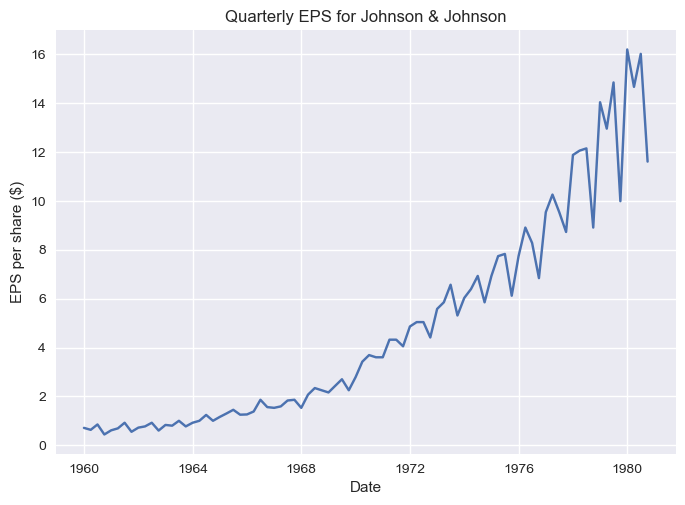

In [5]:
fig, ax = plt.subplots()
ax.plot(data)
ax.set_title('Quarterly EPS for Johnson & Johnson')
ax.set_ylabel('EPS per share ($)')
ax.set_xlabel('Date')
plt.show()

### Seasonality?

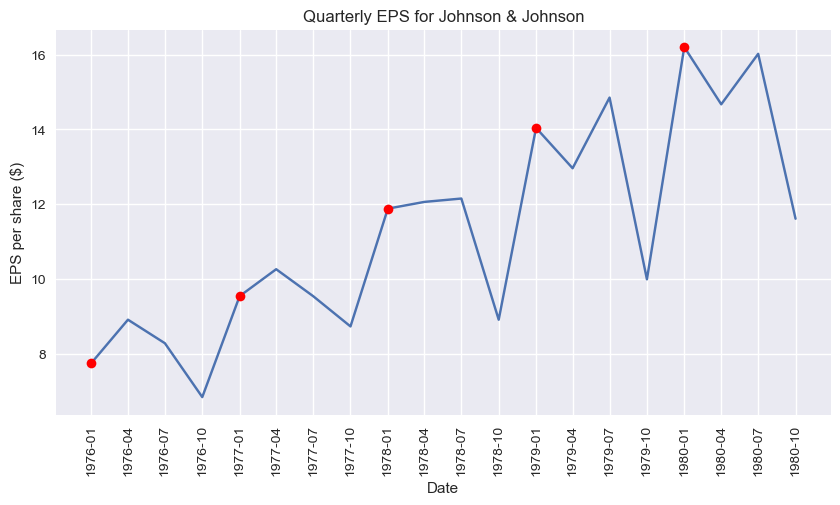

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.loc['1976':]['data'], markevery=4, marker='o', markerfacecolor='red')
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.set_title('Quarterly EPS for Johnson & Johnson')
ax.set_ylabel('EPS per share ($)')
ax.set_xlabel('Date')
plt.xticks(rotation=90)
plt.show()

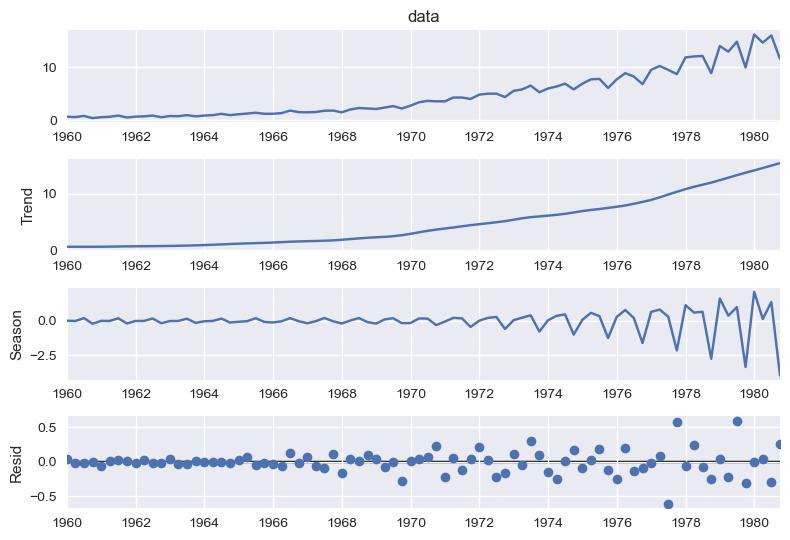

In [7]:
from statsmodels.tsa.seasonal import STL
seas_decomp = STL(data['data'], period=4).fit()
seas_decomp.plot()
plt.show()

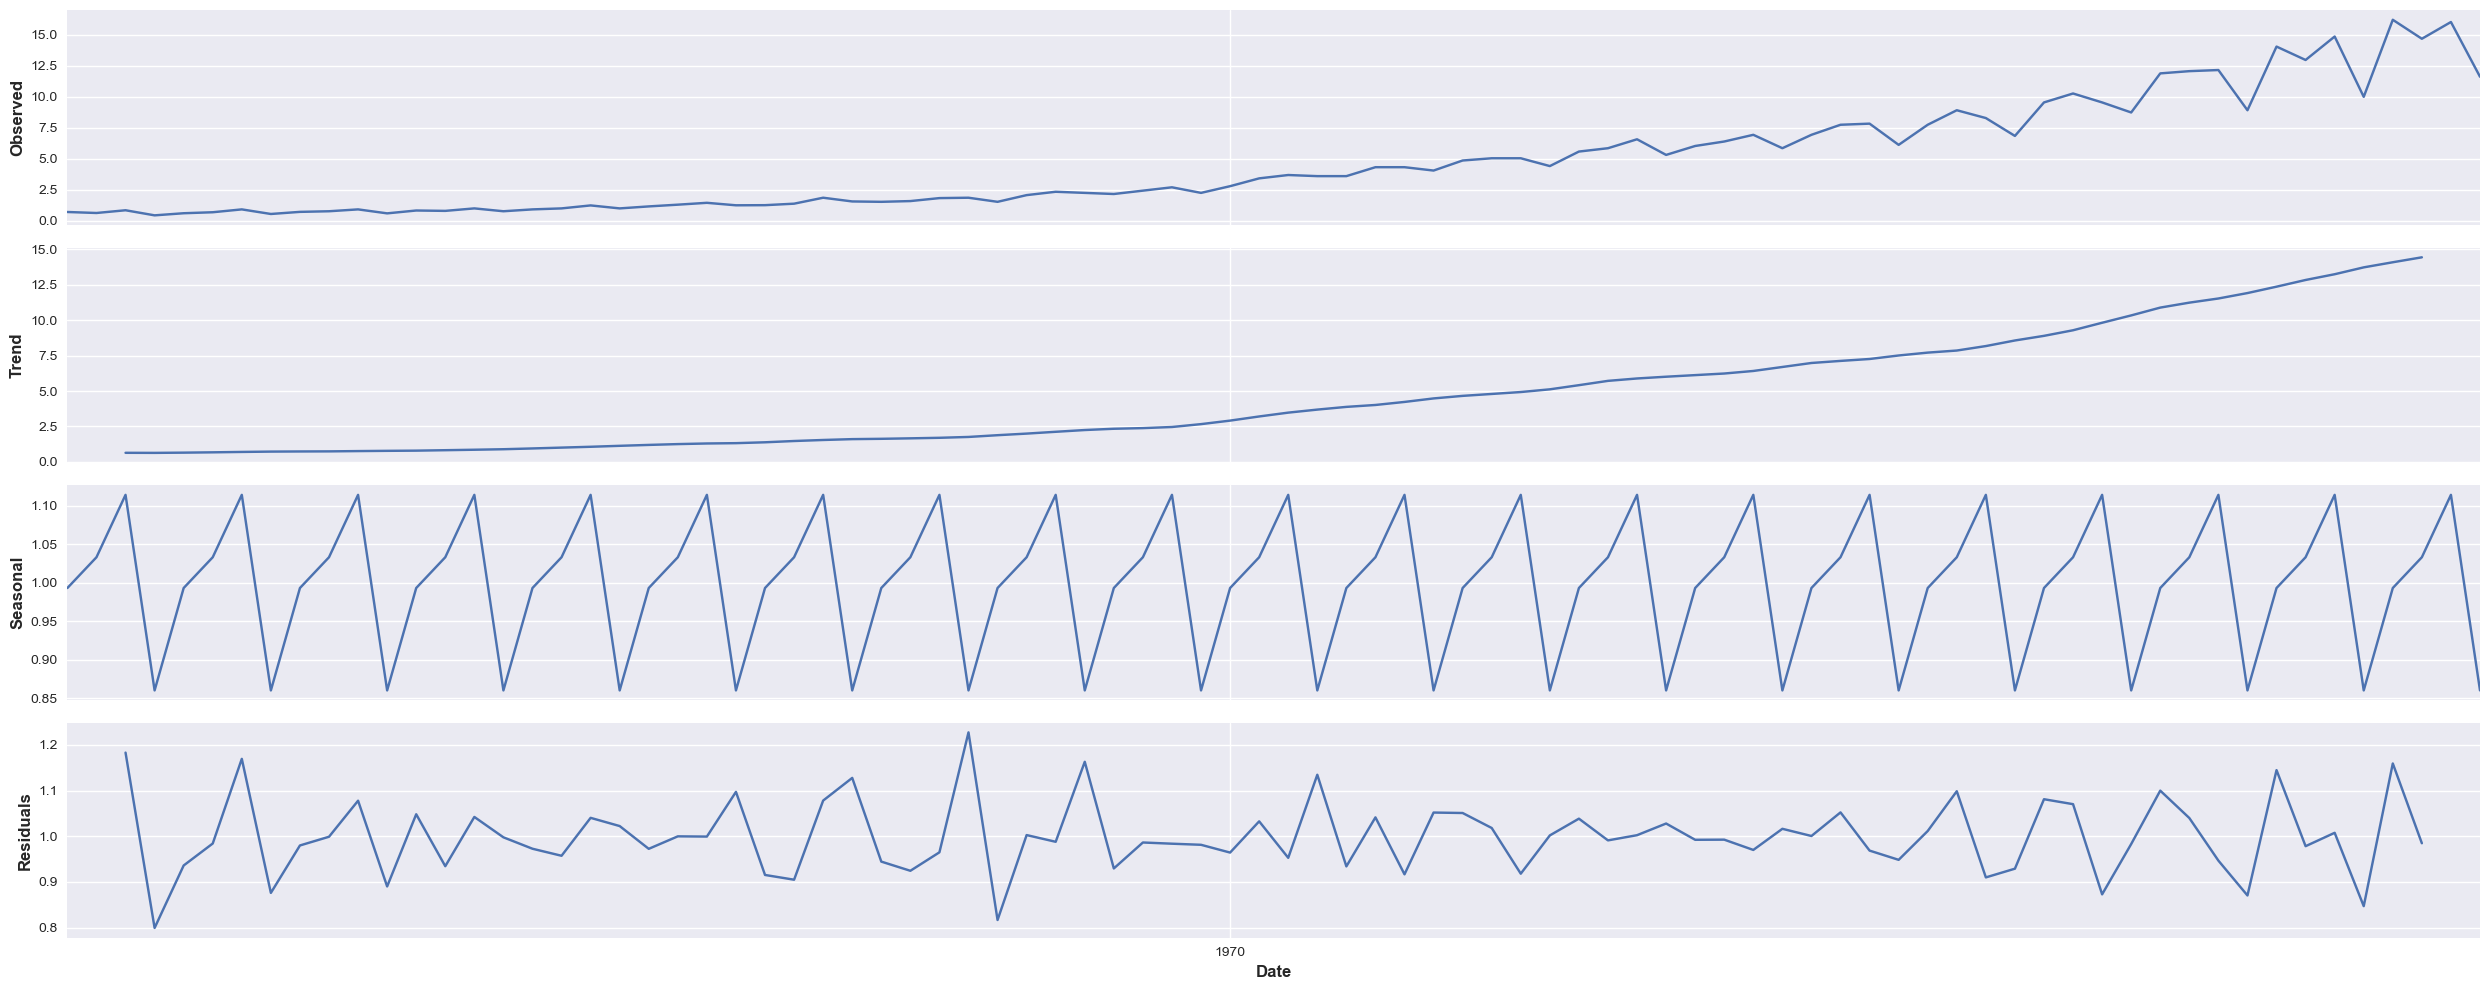

In [8]:
tt.seasonal_decomp(data['data'], period=None, model_type='multiplicative')

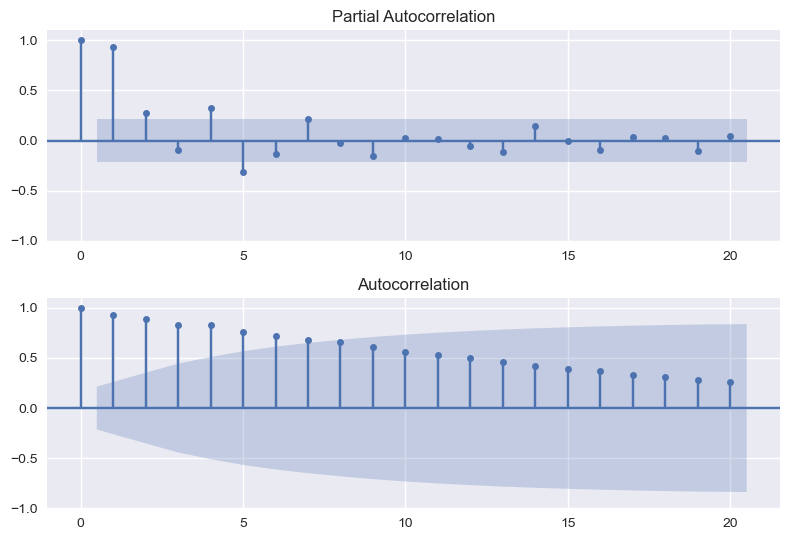

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_pacf(data, ax=ax1)
ax1.set_ylim(top=1.1)
plot_acf(data, ax=ax2)
ax2.set_ylim(top=1.1)
plt.tight_layout();

In [10]:
tt.adf_v2(data['data'])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                  2.742017
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [11]:
tt.adf_v2(data['data'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -0.407410
p-value                         0.908854
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [12]:
tt.adf_v2(data['data'], diff=2)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=2

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is stationary.


In [13]:
tt.adf_v2(data['data'].diff(1)[1:], diff=4)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=4

Test Statistic                -6.032499e+00
p-value                        1.407057e-07
#Lags Used                     1.200000e+01
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
dtype: float64

The time series is stationary.


#### log and difference of order 1

In [14]:
tt.adf_v2(np.log(data['data']), diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -4.317044
p-value                         0.000415
#Lags Used                      5.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64

The time series is stationary.


In [15]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,data,data_tr_1
1960-01-01,0.71,NaN
1960-04-01,0.63,-0.119545
1960-07-01,0.85,0.299517
1960-10-01,0.44,-0.658462
1961-01-01,0.61,0.326684
1961-04-01,0.69,0.123233
1961-07-01,0.92,0.287682
1961-10-01,0.55,-0.514455
1962-01-01,0.72,0.269333
1962-04-01,0.77,0.067139


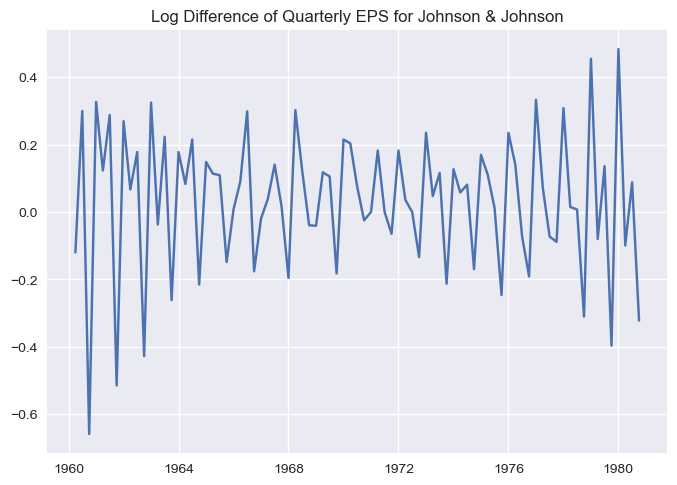

In [16]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [17]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811829
p-value: 0.00041497314044407825


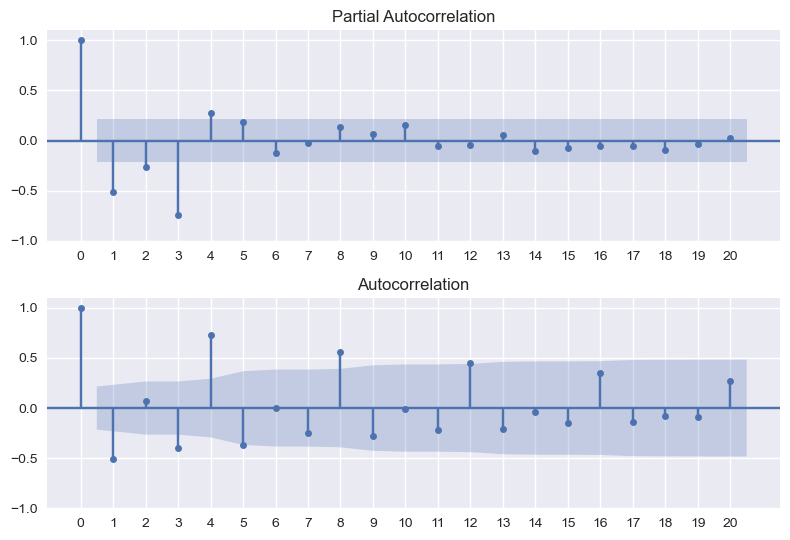

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_pacf(data['data_tr_1'][1:], ax=ax1)
ax1.set_ylim(-1, 1.1)
ax1.xaxis.set_major_locator(mticker.FixedLocator(np.arange(0, 21)))
ax1.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,}'))
plot_acf(data['data_tr_1'][1:],ax=ax2)
ax2.set_ylim(-1, 1.1)
ax2.xaxis.set_major_locator(mticker.FixedLocator(np.arange(0, 21)))
plt.tight_layout();

## Log-transformation

In [43]:
data['data_log'] = np.log(data['data'])
data.head()

,data,data_tr_1,data_log
1960-01-01,0.71,NaN,-0.342490
1960-04-01,0.63,-0.119545,-0.462035
1960-07-01,0.85,0.299517,-0.162519
1960-10-01,0.44,-0.658462,-0.820981
1961-01-01,0.61,0.326684,-0.494296


## Stationarity

In [45]:
# tt.adf_v2(data['data_log'], diff=0)
tt.adf_v2(data['data_log'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -4.317044
p-value                         0.000415
#Lags Used                      5.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64

The time series is stationary.


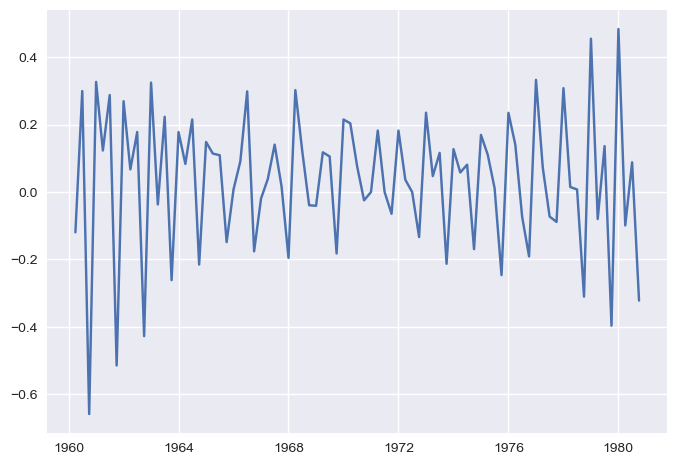

In [51]:
plt.plot(data['data_log'].diff(1));

## ARIMA model

In [72]:
ps = range(0, 5, 1) 
qs = range(0, 5, 1)

ARIMA_order_list = list(product(ps, qs)) 

train = data['data_log'][:-4]
d=1
ARIMA_result_df = tt.optimize_ARIMA(train, ARIMA_order_list, d,) 

  0%|          | 0/25 [00:00<?, ?it/s]

In [73]:
ARIMA_result_df.head(10)

,"(p,q)",AIC
0,"(4, 3)",-132.545869
1,"(4, 1)",-131.948410
2,"(4, 2)",-131.004998
3,"(4, 4)",-130.509564
4,"(4, 0)",-118.962489
5,"(3, 4)",-111.955775
6,"(3, 3)",-108.014773
7,"(3, 2)",-98.962518
8,"(1, 4)",-87.125409
9,"(2, 4)",-85.483489


In [74]:
def get_best_order(tup, seasonal=True):
    if seasonal:
        order = list(tup)
        order.insert(1, d)
        order.insert(4, D)
        order.append(s)
        print('order = {}'.format(tuple(order)[:3]))
        print('seasonal order = {}'.format(tuple(order)[3:]))
        return tuple(order)[:3], tuple(order)[3:]
    else:
        order = list(tup)
        order.insert(1, d)
        print('order = {}'.format(tuple(order)[:3]))
        return tuple(order)[:3]

In [75]:
tso1 = get_best_order(ARIMA_result_df['(p,q)'][0], seasonal=False)

order = (4, 1, 3)


In [88]:
# order=([0,0,0,1], 1, [1,0,1])
ARIMA_model = SARIMAX(train, order=([4], 1, [1,3]), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:                    data_log   No. Observations:                   80
Model:             SARIMAX([4], 1, [1, 3])   Log Likelihood                  73.413
Date:                     Thu, 12 Jan 2023   AIC                           -138.826
Time:                             21:36:38   BIC                           -129.348
Sample:                         01-01-1960   HQIC                          -135.028
                              - 10-01-1979                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L4          0.9401      0.035     26.757      0.000       0.871       1.009
ma.L1         -0.5894      0.110     -5.359      0.000      -0.805      -0.374
ma.L3       

In [95]:
ARIMA_model = SARIMAX(train, order=tso1, simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               data_log   No. Observations:                   80
Model:               SARIMAX(4, 1, 3)   Log Likelihood                  74.273
Date:                Thu, 12 Jan 2023   AIC                           -132.546
Time:                        21:38:46   BIC                           -113.590
Sample:                    01-01-1960   HQIC                          -124.952
                         - 10-01-1979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0030      0.063      0.048      0.962      -0.120       0.125
ar.L2          0.0195      0.052      0.372      0.710      -0.083       0.122
ar.L3          0.0219      0.051      0.428      0.6

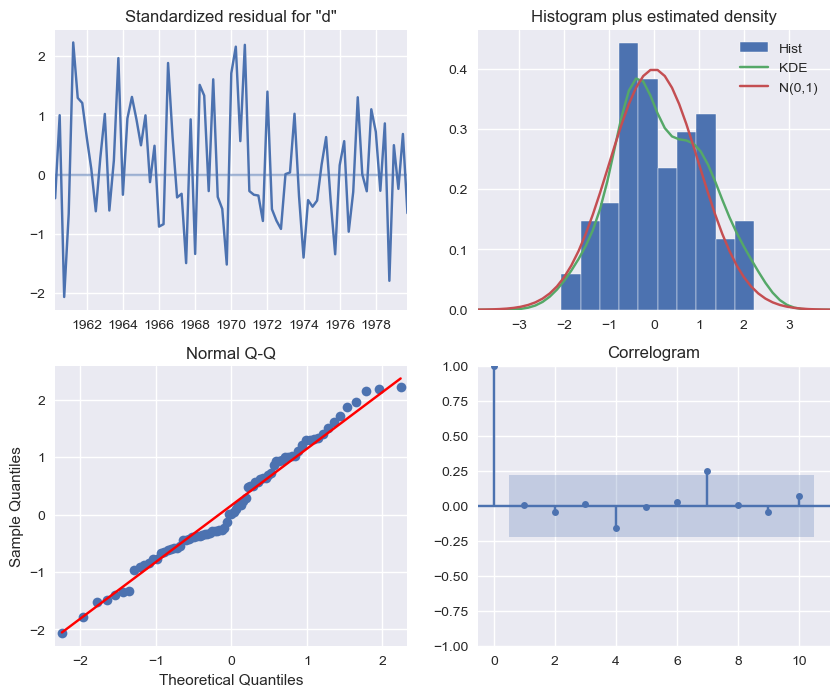

In [96]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.23 > 0.05
The residuals are independent and not correlated.  Like white noise!


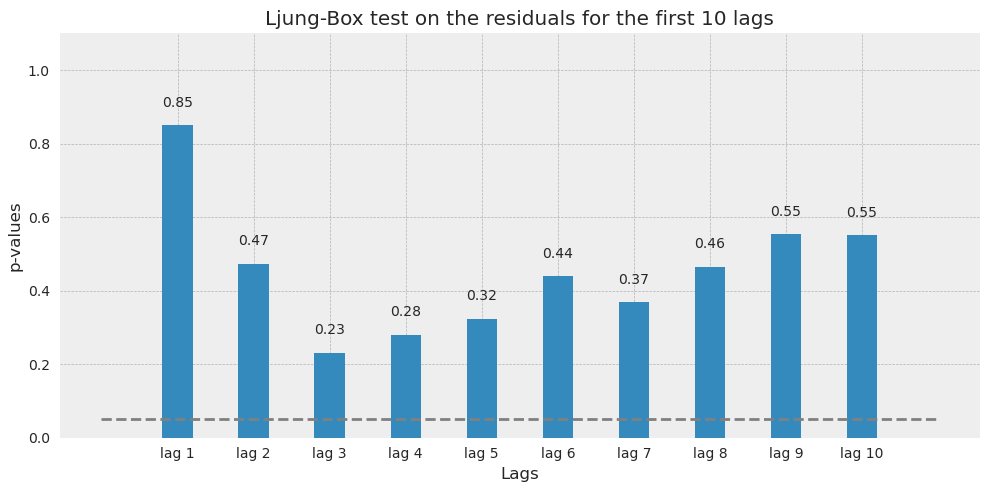

In [97]:
tt.ljungbox(ARIMA_model_fit.resid)

In [98]:
import datetime

dti = pd.date_range("1979-12-01", periods=12, freq="QS")

pred = ARIMA_model_fit.forecast(12)
pred_transformed = np.exp(pred)
preds = pd.DataFrame(pred_transformed.values, index=dti, columns=['prediction'])

In [99]:
test = data[-4:] 
test = pd.concat([test, preds], axis=1)
test

,data,data_tr_1,data_log,prediction
1980-01-01,16.20,0.483427,2.785011,16.095385
1980-04-01,14.67,-0.099207,2.685805,14.534904
1980-07-01,16.02,0.088033,2.773838,16.801274
1980-10-01,11.61,-0.321971,2.451867,11.691526
1981-01-01,NaN,NaN,NaN,18.270834
1981-04-01,NaN,NaN,NaN,16.562991
1981-07-01,NaN,NaN,NaN,18.981001
1981-10-01,NaN,NaN,NaN,13.625267
1982-01-01,NaN,NaN,NaN,20.692885
1982-04-01,NaN,NaN,NaN,18.832598


## Plot results

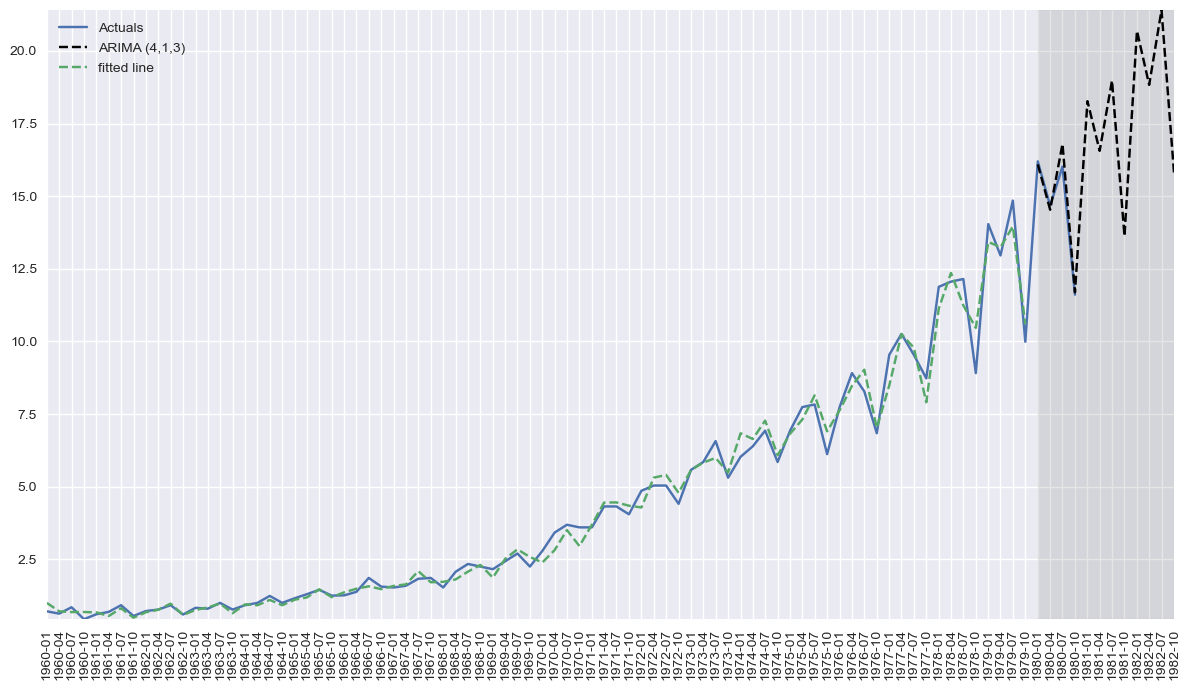

In [100]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data.loc['1960':]['data'], label='Actuals')
ax.plot(preds, ls='--', color='black', label='ARIMA (4,1,3)')
ax.plot(np.exp(ARIMA_model_fit.fittedvalues), label='fitted line', ls='--')
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.axvspan('1980-01-01', '1982-10-01', color='#808080', alpha=0.2)
plt.xticks(rotation = 90)
plt.margins(0)
plt.legend()
plt.tight_layout();

In [101]:
mse = mean_squared_error(test[:4]['data'], test[:4]['prediction'])
mape = tt.mape(test['data'][:4], test['prediction'][:4])
print('mse = {0:0.6f}'.format(mse))
print('mape = {0:0.6f}'.format(mape))

mse = 0.161558
mape = 1.786435


## SARIMA model

In [ ]:
ps = range(0, 5, 1) 
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs)) 

train = np.log(data['data'])[:-4] 
d=2 
D=0 
s = 4
SARIMA_result_df = tt.optimize_SARIMA(train, SARIMA_order_list, d, D, s) 

In [21]:
SARIMA_result_df.head(10)

,"(p,q,P,Q)",AIC
0,"(2, 4, 2, 0)",-133.489392
1,"(0, 2, 2, 0)",-133.410656
2,"(0, 2, 1, 1)",-133.147222
3,"(0, 2, 3, 1)",-133.035770
4,"(0, 4, 1, 0)",-132.595403
5,"(0, 4, 2, 0)",-131.624506
6,"(0, 2, 3, 0)",-131.537285
7,"(3, 1, 0, 1)",-131.495837
8,"(0, 2, 2, 1)",-131.489096
9,"(2, 4, 3, 0)",-131.465402


#### select **order** and **seasonal order** with lowest AIC

In [23]:
tso1, tso2 = get_best_order(SARIMA_result_df['(p,q,P,Q)'][0])

order = (2, 2, 4)
seasonal order = (2, 0, 0, 4)


In [24]:
SARIMA_model = SARIMAX(train, order=tso1, seasonal_order=tso2, simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 2, 4)x(2, 0, [], 4)   Log Likelihood                  75.745
Date:                            Thu, 12 Jan 2023   AIC                           -133.489
Time:                                    19:09:28   BIC                           -112.279
Sample:                                01-01-1960   HQIC                          -124.998
                                     - 10-01-1979                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2873      0.139     -9.281      0.000      -1.559      -1.015
ar.L2         -0.7497      0.148   

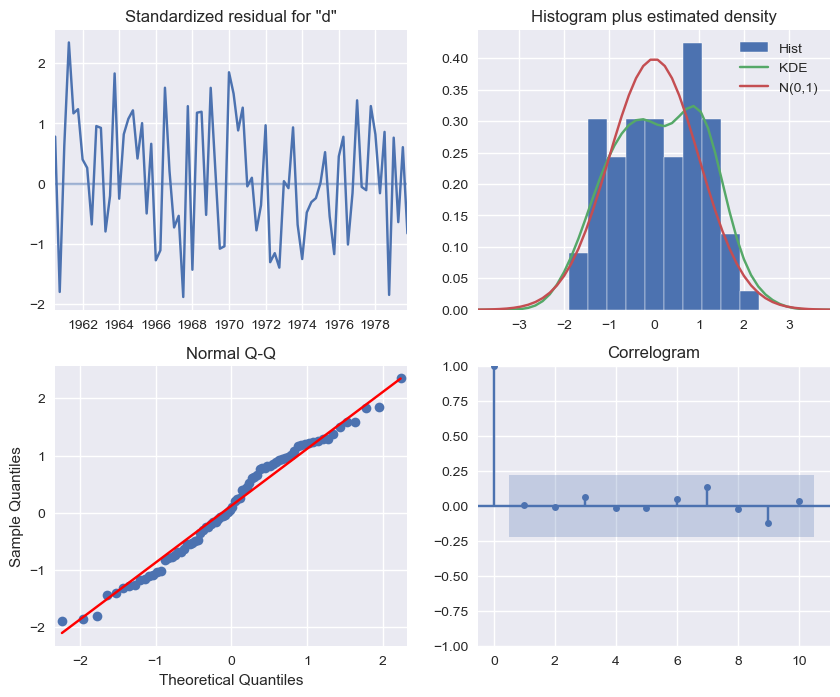

In [25]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.01 < 0.05
The residuals are correlated.  Not good.


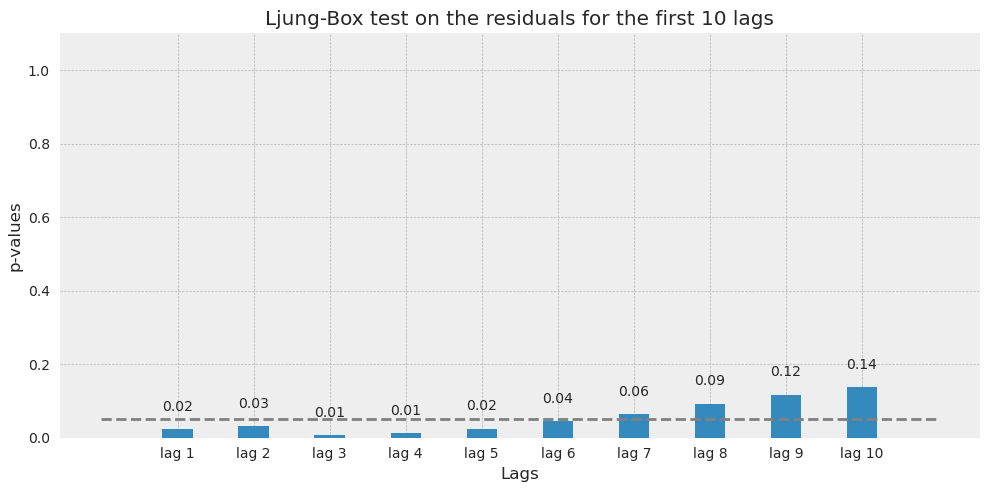

In [26]:
tt.ljungbox(SARIMA_model_fit.resid)

,data,prediction
1980-01-01,2.785011,16.193811
1980-04-01,2.685805,14.650376
1980-07-01,2.773838,16.993951
1980-10-01,2.451867,11.839711
1981-01-01,NaN,18.617835
1981-04-01,NaN,16.919770
1981-07-01,NaN,19.469236
1981-10-01,NaN,14.007915
1982-01-01,NaN,21.410231
1982-04-01,NaN,19.547454


In [27]:
test = data['data'][-4:] 
test

1980-01-01    16.20
1980-04-01    14.67
1980-07-01    16.02
1980-10-01    11.61
Freq: QS-JAN, Name: data, dtype: float64

In [28]:
import datetime

dti = pd.date_range("1979-12-01", periods=12, freq="QS")
dti

DatetimeIndex(['1980-01-01', '1980-04-01', '1980-07-01', '1980-10-01',
               '1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01',
               '1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01'],
              dtype='datetime64[ns]', freq='QS-JAN')

In [29]:
pred = SARIMA_model_fit.forecast(12)
pred_transformed = np.exp(pred)
preds = pd.DataFrame(pred_transformed.values, index=dti, columns=['prediction'])

In [30]:
np.exp(SARIMA_model_fit.fittedvalues)

1960-01-01     1.000000
1960-04-01     0.598257
1960-07-01     0.559014
1960-10-01     0.839359
1961-01-01     0.487672
                ...    
1978-10-01    10.421236
1979-01-01    13.162120
1979-04-01    13.682903
1979-07-01    14.109160
1979-10-01    10.715525
Freq: QS-JAN, Length: 80, dtype: float64

In [31]:
test = pd.concat([test, preds], axis=1)
test

,data,prediction
1980-01-01,16.20,16.347269
1980-04-01,14.67,15.068434
1980-07-01,16.02,16.537244
1980-10-01,11.61,11.989308
1981-01-01,NaN,18.236093
1981-04-01,NaN,17.416584
1981-07-01,NaN,19.120519
1981-10-01,NaN,13.670207
1982-01-01,NaN,21.260534
1982-04-01,NaN,19.771242


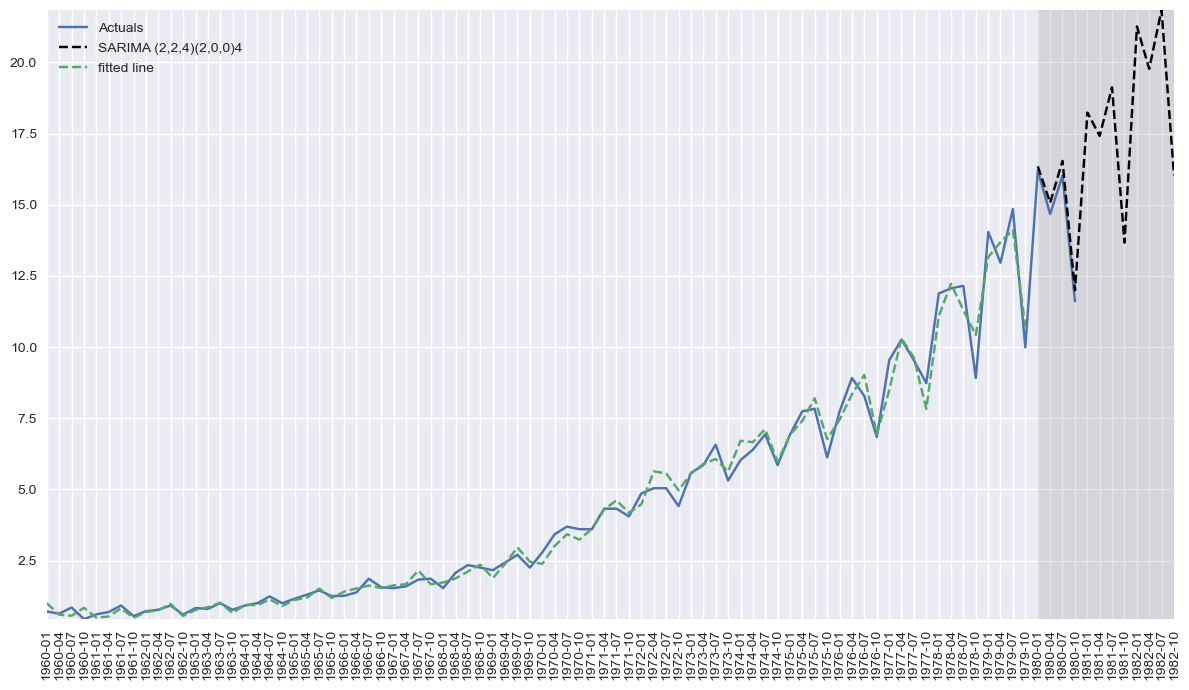

In [32]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data.loc['1960':]['data'], label='Actuals')
ax.plot(preds, ls='--', color='black', label='SARIMA (2,2,4)(2,0,0)4')
ax.plot(np.exp(SARIMA_model_fit.fittedvalues), label='fitted line', ls='--')
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.axvspan('1980-01-01', '1982-10-01', color='#808080', alpha=0.2)
plt.xticks(rotation = 90)
plt.margins(0)
plt.legend()
plt.tight_layout();

In [33]:
test[:4]

,data,prediction
1980-01-01,16.20,16.347269
1980-04-01,14.67,15.068434
1980-07-01,16.02,16.537244
1980-10-01,11.61,11.989308


In [34]:
mse = mean_squared_error(test[:4]['data'], test[:4]['prediction'])
print('mse = {0:0.6f}'.format(mse))

mse = 0.147963


In [35]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mape(test['data'][:4], test['prediction'][:4])

2.5302167203676325